In [1]:
from ib_insync import *
from IPython.display import display, clear_output
import pandas as pd
import numpy as np
import datetime as dt
import joblib
import time
import telegram
import matplotlib.pyplot as plt
util.startLoop()

In [2]:
def fetch_eurusd_data(duration='1 Y', bar_size='5 mins'):
    ib = IB()
    ib.connect()
    contract = Forex('EURUSD')
    
    # Use the current date and time as the start date
    end_date = dt.datetime.now()
    end_date_str = end_date.strftime('%Y%m%d %H:%M:%S') + ' US/Eastern'
    
    data = ib.reqHistoricalData(
        contract,
        endDateTime=end_date_str,
        durationStr=duration,
        barSizeSetting=bar_size,
        whatToShow='BID',
        useRTH=True,
        formatDate=2,
        timeout=0
    )
    
    df = util.df(data)
    df = df[['date', 'close']]
    
    return df

In [3]:
df = fetch_eurusd_data()

In [4]:
df['close_mul'] = df['close']*100000
df.set_index('date', inplace=True)
df

,close,close_mul
date,,
2023-05-16 21:15:00+00:00,1.08618,108618.0
2023-05-16 21:20:00+00:00,1.08624,108624.0
2023-05-16 21:25:00+00:00,1.08618,108618.0
2023-05-16 21:30:00+00:00,1.08617,108617.0
2023-05-16 21:35:00+00:00,1.08632,108632.0
...,...,...
2024-05-14 16:25:00+00:00,1.08156,108156.0
2024-05-14 16:30:00+00:00,1.08185,108185.0
2024-05-14 16:35:00+00:00,1.08179,108179.0


In [5]:
data_model = pd.DataFrame()
data_model['price'] = df['close_mul']
data_model['target'] = df['close_mul'].shift(-4) - df['close_mul']
for i in range(5):
    data_model[f'lag_{i}'] = df['close_mul'].shift(i) - df['close_mul'].shift(i+1)
for i in range(5):
    data_model[f'ret_{i}'] = df['close_mul'] - df['close_mul'].shift(i)
data_model.dropna(inplace=True)
data_model.index = pd.to_datetime(data_model.index)
data_model

,price,target,lag_0,lag_1,lag_2,lag_3,lag_4,ret_0,ret_1,ret_2,ret_3,ret_4
date,,,,,,,,,,,,
2023-05-16 21:40:00+00:00,108612.0,9.0,-20.0,15.0,-1.0,-6.0,6.0,0.0,-20.0,-5.0,-6.0,-12.0
2023-05-16 21:45:00+00:00,108615.0,3.0,3.0,-20.0,15.0,-1.0,-6.0,0.0,3.0,-17.0,-2.0,-3.0
2023-05-16 21:50:00+00:00,108615.0,0.0,0.0,3.0,-20.0,15.0,-1.0,0.0,0.0,3.0,-17.0,-2.0
2023-05-16 21:55:00+00:00,108619.0,4.0,4.0,0.0,3.0,-20.0,15.0,0.0,4.0,4.0,7.0,-13.0
2023-05-16 22:00:00+00:00,108621.0,6.0,2.0,4.0,0.0,3.0,-20.0,0.0,2.0,6.0,6.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-14 16:05:00+00:00,108161.0,-5.0,6.0,-28.0,-31.0,-3.0,41.0,0.0,6.0,-22.0,-53.0,-56.0
2024-05-14 16:10:00+00:00,108174.0,11.0,13.0,6.0,-28.0,-31.0,-3.0,0.0,13.0,19.0,-9.0,-40.0
2024-05-14 16:15:00+00:00,108162.0,17.0,-12.0,13.0,6.0,-28.0,-31.0,0.0,-12.0,1.0,7.0,-21.0


In [6]:
def backtest_price(price_series, position_series):
    bt = pd.DataFrame(price_series.diff() * position_series.shift())
    bt['Date'] = [str(i)[:10] for i in bt.index]
    daily_pnl = bt.groupby('Date').sum()
    return daily_pnl

<AxesSubplot:xlabel='Date'>

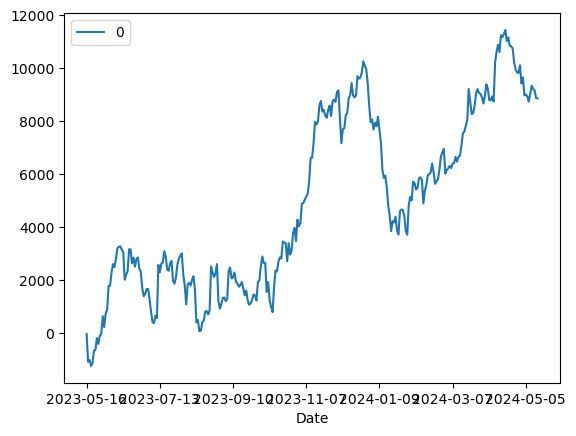

In [7]:
model = joblib.load('lasso_model.joblib')
f_names = ['lag_0', 'lag_1', 'lag_2', 'lag_3']
predictions = model.predict(data_model[f_names])

prediction_series = pd.Series(predictions)
moving_avg = prediction_series.rolling(window=10).mean()

# Determine positions using the predictions & moving average
def determine_position(pred, ma):
    if pred > ma:
        return 1  # Long
    elif pred < ma:
        return -1  # Short
    else:
        return 0  # Neutral

data_model['position'] = [determine_position(p, ma) for p, ma in zip(predictions, moving_avg)]

backtest_price(data_model['price'], data_model['position']).cumsum().plot()

In [8]:
data_model

,price,target,lag_0,lag_1,lag_2,lag_3,lag_4,ret_0,ret_1,ret_2,ret_3,ret_4,position
date,,,,,,,,,,,,,
2023-05-16 21:40:00+00:00,108612.0,9.0,-20.0,15.0,-1.0,-6.0,6.0,0.0,-20.0,-5.0,-6.0,-12.0,0
2023-05-16 21:45:00+00:00,108615.0,3.0,3.0,-20.0,15.0,-1.0,-6.0,0.0,3.0,-17.0,-2.0,-3.0,0
2023-05-16 21:50:00+00:00,108615.0,0.0,0.0,3.0,-20.0,15.0,-1.0,0.0,0.0,3.0,-17.0,-2.0,0
2023-05-16 21:55:00+00:00,108619.0,4.0,4.0,0.0,3.0,-20.0,15.0,0.0,4.0,4.0,7.0,-13.0,0
2023-05-16 22:00:00+00:00,108621.0,6.0,2.0,4.0,0.0,3.0,-20.0,0.0,2.0,6.0,6.0,9.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-14 16:05:00+00:00,108161.0,-5.0,6.0,-28.0,-31.0,-3.0,41.0,0.0,6.0,-22.0,-53.0,-56.0,1
2024-05-14 16:10:00+00:00,108174.0,11.0,13.0,6.0,-28.0,-31.0,-3.0,0.0,13.0,19.0,-9.0,-40.0,1
2024-05-14 16:15:00+00:00,108162.0,17.0,-12.0,13.0,6.0,-28.0,-31.0,0.0,-12.0,1.0,7.0,-21.0,1


In [9]:
data_model['position'].value_counts()

position
 1    36762
-1    36634
 0        9
Name: count, dtype: int64

In [10]:
def paper_trade():
    data = fetch_eurusd_data()
    data['close_mul'] = data['close'] * 100000
    data.set_index('date', inplace=True)
    data_model = pd.DataFrame()
    data_model['price'] = data['close_mul']
    data_model['target'] = data['close_mul'].shift(-4) - data['close_mul']
    for i in range(5):
        data_model[f'lag_{i}'] = data['close_mul'].shift(i) - data['close_mul'].shift(i+1)
    for i in range(5):
        data_model[f'ret_{i}'] = data['close_mul'] - data['close_mul'].shift(i)
    data_model.dropna(inplace=True)
    data_model.index = pd.to_datetime(data_model.index)
    model = joblib.load('lasso_model.joblib')
    f_names = ['lag_0', 'lag_1', 'lag_2', 'lag_3']
    predictions = model.predict(data_model[f_names])
    prediction_series = pd.Series(predictions)
    moving_avg = prediction_series.rolling(window=10).mean()
    
    def determine_position(pred, ma):
        if pred > ma:
            return 1
        elif pred < ma:
            return -1
        else:
            return 0
    
    data_model['position'] = [determine_position(p, ma) for p, ma in zip(predictions, moving_avg)]
    bt = backtest_price(data_model['price'], data_model['position'])
    
    try:
        bot = telegram.Bot(token='7117934389:AAFvk_lHb-kKg8Z75z2gZ4NwSjIleetHjdQ') # create telegram chatbot to track trades and pnl
        message = f'Last trade position: {np.round(data_model["position"].iloc[-1], 2)}, ' \
                  f'Last trade time: {data_model.index[-1]}, ' \
                  f'Today total gain: {np.round(bt.iloc[-1][0], 2)}'
        bot.send_message(chat_id='-4186163291', text=message, parse_mode='HTML')
    except Exception as ex:
        print(ex)

while True:
    paper_trade()
    time.sleep(5*60)  # 5 minutes interval

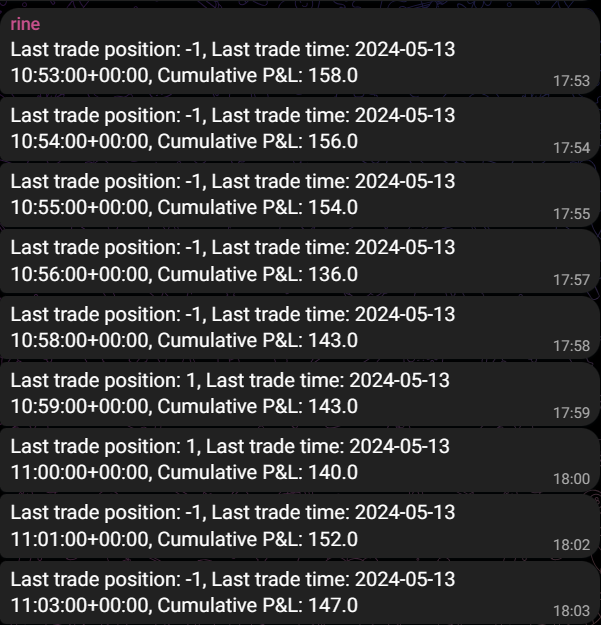

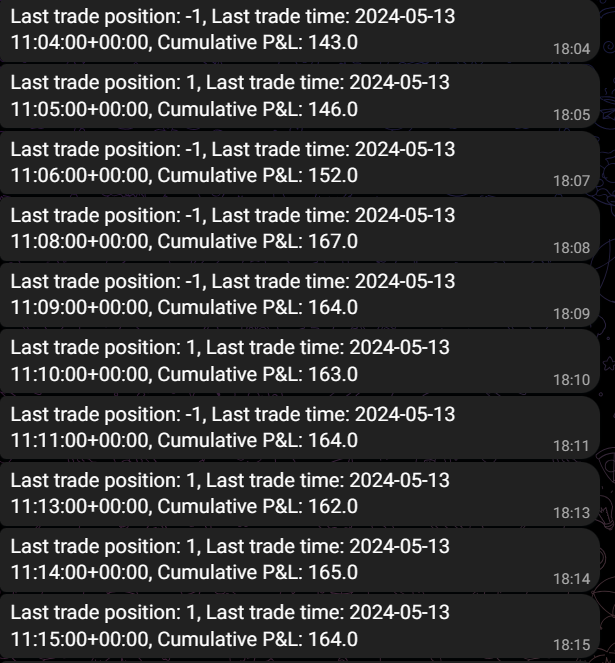

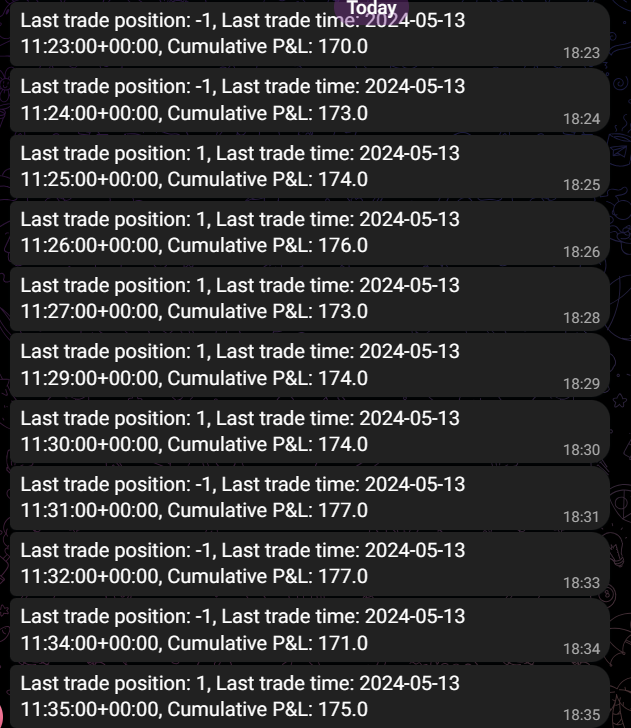

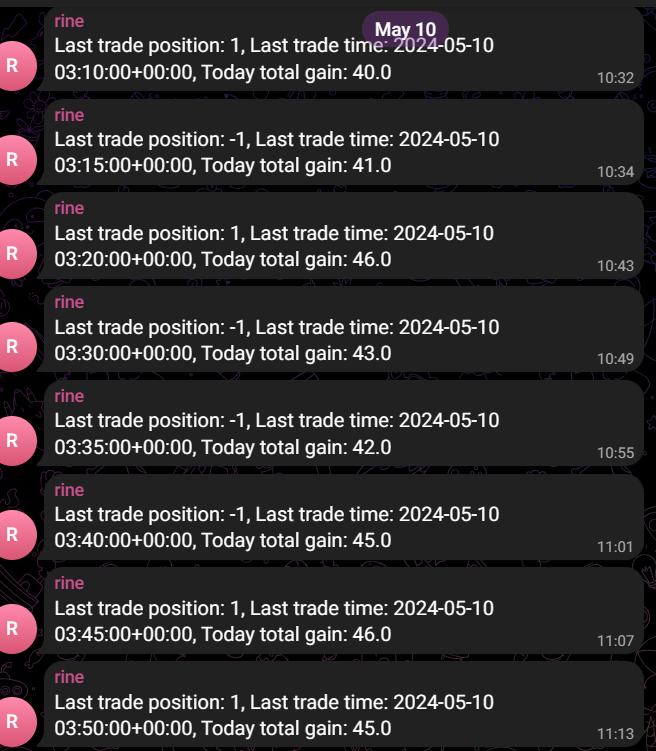